<a href="https://colab.research.google.com/github/blancavazquez/Analisis-datos-masivos-2024/blob/main/notebooks/1_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reducción de dimensiones mediante análisis de componentes principales (ACP)
En esta libreta exploraremos la reducción de dimensiones con análisis de componentes principales (ACP). Libreta creada por Gibran Fuentes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Definición
Dado un conjunto de ejemplos $\mathbf{X} = \{\mathbf{x}^{(i)} \in \mathbb{R}^d\mid i = 1, \ldots, n\}$, el análisis de componentes principales busca encontrar los vectores $\mathbf{u}_1, \ldots, \mathbf{u}_K$, donde K es usualmente mucho menor a $d$ que maximicen la varianza.

Esto puede lograrse obteniendo los $K$ eigenvectores con mayor eigenvalor $\lambda_1, \ldots, \lambda_K$ de la matriz de covarianza $\boldsymbol{\Sigma}$, definida por

$
\boldsymbol{\Sigma} = \frac{1}{n - 1}\sum_{i=1}^n
(\mathbf{x}^{(i)} - \boldsymbol{\mu}) (\mathbf{x}^{(i)} - \boldsymbol{\mu})^\top
$

Los $K$ eigenvectores se conocen como componentes principales.

In [2]:
class PCA:
  def __init__(self, n_components):
    self.n_components_ = n_components

  def fit(self, X):
    self.means_ = X.mean(axis=0)
    devs = X - self.means_

    cov = (devs.T @ devs) / (X.shape[0] - 1)
    l, u = np.linalg.eig(cov)

    lts = l.argsort()[::-1]
    u = u[:, lts]
    l = l[lts]

    self.components_ = u[:, :self.n_components_]
    self.vars_ = l[:self.n_components_]

  def transform(self, X):
    return (X - self.means_) @ self.components_

  def inverse_transform(self, X_reduced):
    return X_reduced @ self.components_.T + self.means_

De forma alternativa, podemos calcular los componentes principales por medio de de la descomposición SVD
$$
\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^{\top}
$$

Los vectores propios de la matriz de covarianza $\mathbf{X}\mathbf{X}^\top$ se corresponden con $\mathbf{U}$ y sus valores propios asociados con la diagonal de $\mathbf{D}$. Esto es,

\begin{align*}
\mathbf{X} \mathbf{X}^\top & = \left(\mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^{\top}\right) \left(\mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^{\top}\right)^\top = \mathbf{U} \boldsymbol{\Sigma} \underbrace{\mathbf{V}^\top \mathbf{V}}_{\mathbf{I}} \boldsymbol{\Sigma}^\top \mathbf{U}^{\top}\\
     & = \mathbf{U} \underbrace{\boldsymbol{\Sigma} \boldsymbol{\Sigma}^\top}_{\mathbf{D}} \mathbf{U}^\top = \mathbf{U} \mathbf{D} \mathbf{U}^\top
\end{align*}

In [3]:
class PCASVD:
  def __init__(self, n_components):
    self.n_components_ = n_components

  def fit(self, X):
    self.means_ = X.mean(axis=0)
    X -= self.means_

    U, S, V = np.linalg.svd(X)
    self.vars_ = S[:self.n_components_]**2 / (X.shape[0] - 1)
    self.components_ = V[:self.n_components_].T

  def transform(self, X):
    return (X - self.means_) @ self.components_

  def inverse_transform(self, X_reduced):
    return X_reduced @ self.components_.T + self.means_

## Conjunto de datos de imágenes de dígitos
Cargamos y visualizamos algunos ejemplos del conjunto de imágenes de dígitos

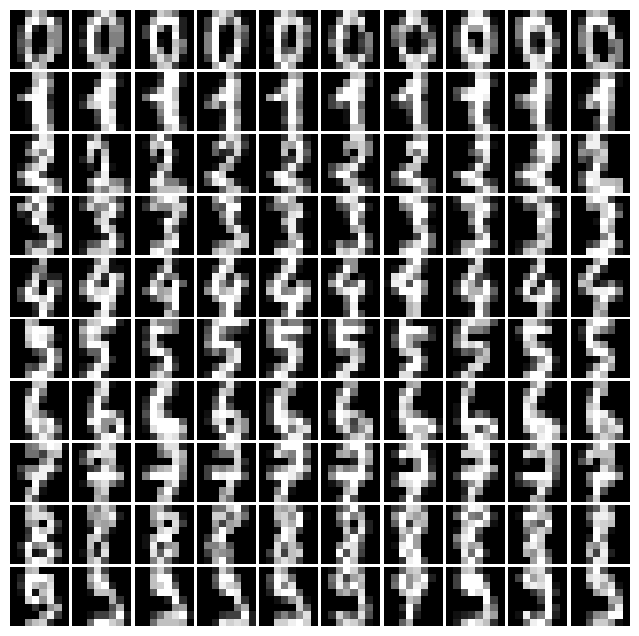

In [13]:
from sklearn.datasets import load_digits
import matplotlib.gridspec as gridspec


def show_images(images, targets, n_targets=False, n_samples=10, imshape=(8,8), figsize=(8,8)):
  n_targets = n_targets if n_targets else targets.max() + 1

  plt.figure(figsize=figsize)
  gs = gridspec.GridSpec(n_targets, n_samples)
  gs.update(wspace=0.05, hspace=0.05)
  for i in range(n_targets):
    target_spec_imgs = images[targets==i]
    for j in range(n_samples):
      ax = plt.subplot(gs[i * n_samples + j])
      ax.imshow(target_spec_imgs[j].reshape(imshape), cmap=plt.cm.gray, interpolation='nearest')
      ax.axis('off')
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.set_aspect('equal')
  plt.show()

db = load_digits()
show_images(db.images, db.target)

Aplicamos PCA con 2 componentes a este conjunto

In [14]:
imgs = db['data']
impca2 = PCA(2)
impca2.fit(imgs)
reduced2 = impca2.transform(imgs)

Visualizamos los datos proyectados en el subespacio

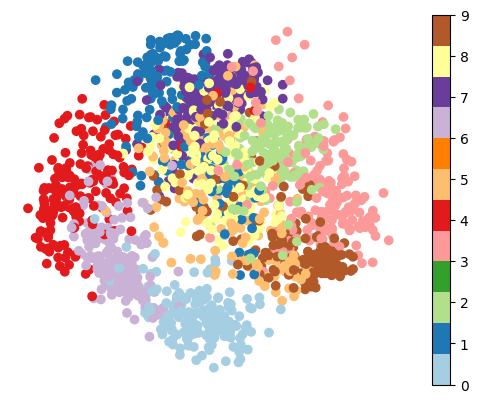

In [15]:
plt.scatter(reduced2[:, 0], reduced2[:, 1], c=db.target, cmap="Paired")
plt.colorbar()
plt.axis('off')
plt.show()

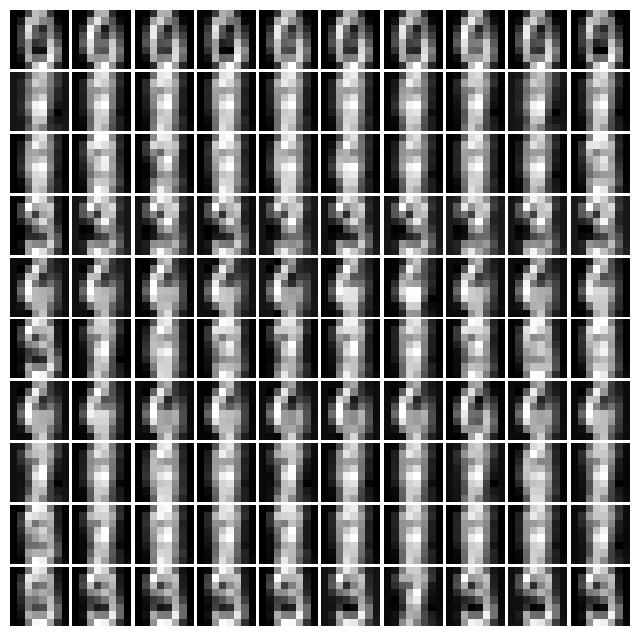

In [16]:
rec2 = impca2.inverse_transform(reduced2)
show_images(rec2.reshape(rec2.shape[0], 8, 8), db.target)

Aplicamos PCA con 40 componentes para comparar las reconstrucciones

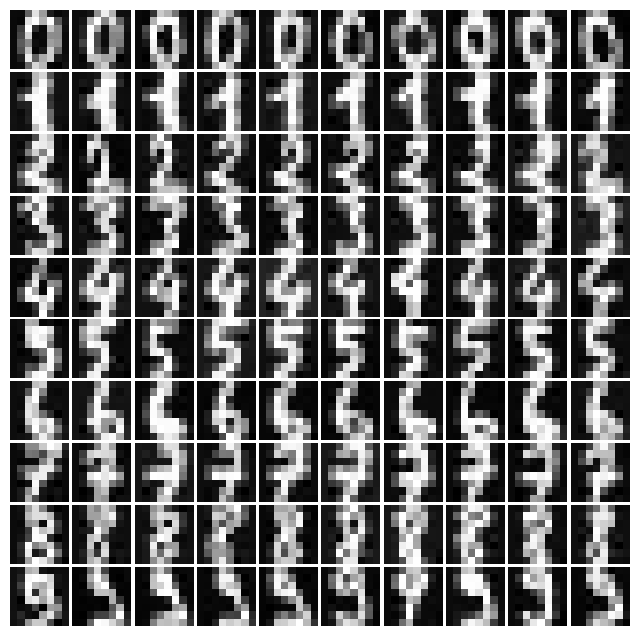

In [17]:
impca40 = PCA(40)
impca40.fit(imgs)
reduced40 = impca40.transform(imgs)
rec40 = impca40.inverse_transform(reduced40)
show_images(rec40.reshape(rec40.shape[0], 8, 8), db.target)

Una estrategia para elegir el número $K$ de componentes principales es analizar el porcentaje de la varianza explicada. Visualicemos el radio de la varianza explicada por cada componente y su porcentaje acumulado.Podemos observar que los primeros 21 componentes principales explican más del 90% de la varianza.

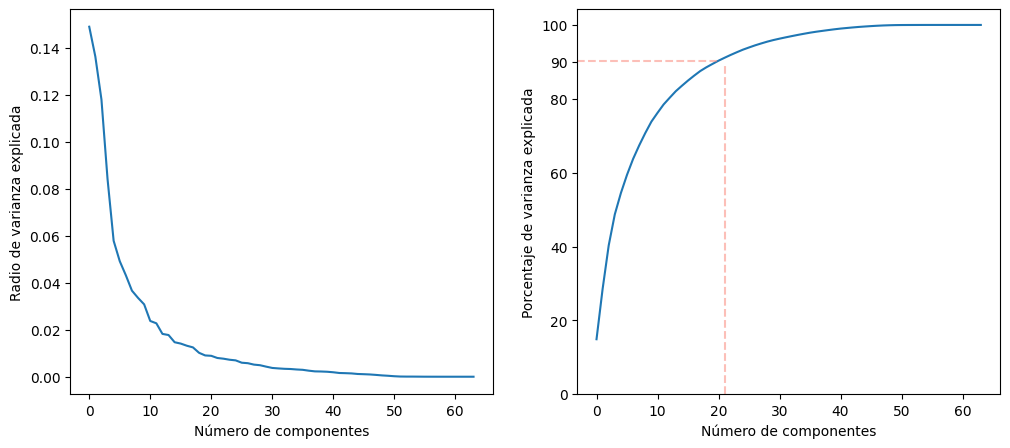

In [18]:
m = PCA(64)
m.fit(imgs)
percent = (m.vars_.cumsum() / m.vars_.sum()) * 100

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs[0].plot(m.vars_ / m.vars_.sum())
axs[0].set_xlabel(u'Número de componentes')
axs[0].set_ylabel(u'Radio de varianza explicada')

axs[1].plot(percent)
axs[1].set_xlabel(u'Número de componentes')
axs[1].set_ylabel(u'Porcentaje de varianza explicada')
axs[1].axvline(x=np.argwhere(percent>=90)[0] + 1, ymin=0, ymax=0.86, color='salmon',alpha=0.5, ls='--')
axs[1].axhline(y=percent[np.argwhere(percent>=90)][0], xmin=0, xmax=0.33, color='salmon', alpha=0.5, ls='--')
axs[1].set_yticks([0,20,40,60,80,90,100])

plt.show()

## Reconocimiento de rostros con PCA
Ahora vamos a explorar un método sencillo de reconocimiento de rostros usando PCA, conocido como _eigenfaces_.

Primero cargamos el conjunto de imágenes de rostros de Olivetti Research Laboratory, el cual contiene imágenes de $64\times 64$ de 40 sujetos distintos.

Visualicemos las imágenes de 10 sujetos.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


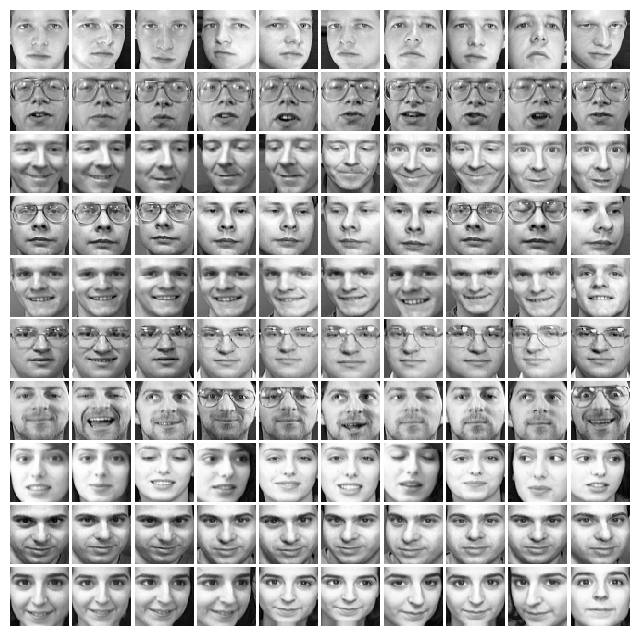

In [19]:
from sklearn.datasets import fetch_olivetti_faces

orl  = fetch_olivetti_faces()
show_images(orl.images, orl.target, n_targets=10, imshape=orl.images[0].shape)

Dividimos el conjunto en subconjuntos de entrenamiento y validación

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(orl.data, orl.target, test_size=0.3, random_state=42)

Tomemos dos imágenes de un mismo rostro y de dos rostros distintos y comparémoslas.

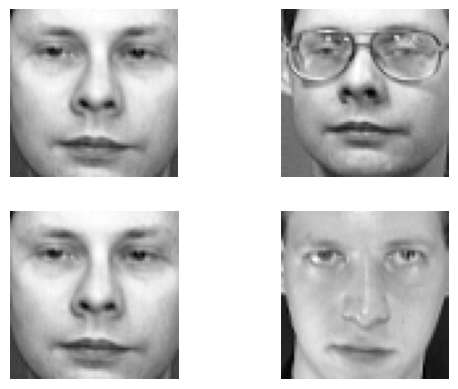

In [21]:
plt.subplot(2,2,1)
plt.imshow(X_train[y_train==3][0].reshape(64, 64), cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_train[y_train==3][4].reshape(64, 64), cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(X_train[y_train==3][0].reshape(64, 64), cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(X_train[y_train==0][1].reshape(64, 64), cmap='gray')
plt.axis('off')
plt.show()

Convertimos las imágenes a vectores de 4096 dimensiones y calculamos la distancia euclidiana entre ambos pares.

In [22]:
dist_sub3_to_sub3 = np.linalg.norm(X_test[y_test==3][2] - X_test[y_test==3][3])
dist_sub3_to_sub4 = np.linalg.norm(X_test[y_test==3][0] - X_test[y_test==4][1])
print(dist_sub3_to_sub3)
print(dist_sub3_to_sub4)

8.3137045
8.281011


Como podemos observar la distancia entre las imágenes del mismo rostro es mayor a la de rostros distintos en el espacio de píxeles, por lo que no sería adecuado para el reconocimiento usar esta representación. Una forma más adecuada de representar las imágenes de los rostros es a través de sus componentes principales.

Apliquemos PCA a nuestro conjunto y visualicemos los componentes principales (_eigenfaces_).

In [23]:
eigenfaces = PCA(20)
eigenfaces.fit(X_train)
X_test_proj = eigenfaces.transform(X_test)

Calculemos la distancia euclidiana de las proyecciones de las imágenes anteriores.

In [24]:
dist_sub3_to_sub3_proj = np.linalg.norm(X_test_proj[y_test==3][2] - X_test_proj[y_test==3][3])
dist_sub3_to_sub4_proj = np.linalg.norm(X_test_proj[y_test==3][0] - X_test_proj[y_test==4][1])
print(dist_sub3_to_sub3_proj)
print(dist_sub3_to_sub4_proj)

4.908253
6.046197


Visualizamos las _eigenfaces_.

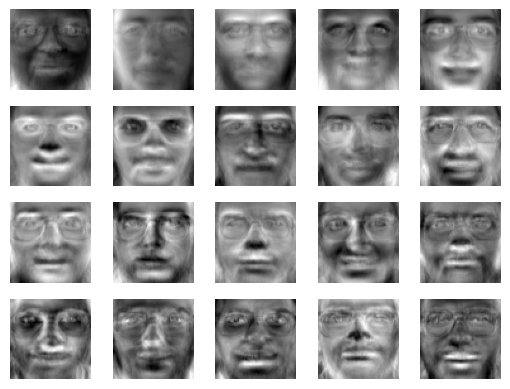

In [25]:
for i in range(eigenfaces.n_components_):
  plt.subplot(4, 5, i+1)
  plt.imshow(eigenfaces.components_.T[i].reshape(64, 64), cmap='gray')
  plt.axis('off')

plt.show()

Finalmente comparamos ambas representaciones para reconocimiento de rostros entrenando y evaluando clasificadores.

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

def entrena_evalua(X, y, ClasePCA, n_components):
  px_scores = []
  ef_scores = []

  cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3)
  for ind_ent, ind_val in cv.split(X, y):
    c1 = SGDClassifier()
    c1.fit(X[ind_ent], y[ind_ent])
    px_scores.append(c1.score(X[ind_val], y[ind_val]))

    ef = ClasePCA(n_components)
    ef.fit(X[ind_ent])
    X_ent_proj = ef.transform(X[ind_ent])
    X_val_proj = ef.transform(X[ind_val])

    c2 = SGDClassifier()
    c2.fit(X_ent_proj, y[ind_ent])
    ef_scores.append(c2.score(X_val_proj, y[ind_val]))

  return px_scores, ef_scores

pxsc, efsc = entrena_evalua(orl.data, orl.target, PCA, n_components=50)
print(f'Exactitud promedio con píxeles: {np.mean(pxsc)} (std = {np.std(pxsc)})')
print(f'Exactitud promedio con eigenfaces: {np.mean(efsc)} (std = {np.std(efsc)})')

Exactitud promedio con píxeles: 0.785 (std = 0.0998749217771909)
Exactitud promedio con eigenfaces: 0.8791666666666665 (std = 0.022806553639006702)


## Proyección de documentos de texto
Ahora vamos a proyectar con PCA los documentos de texto del conjunto de datos de Reuters Corpus Volume I (RCV1), el cual contiene más de 800,000. En particular, usaremos las bolsas de palabras precalculadas de este conjunto disponibles en scikit-learn (ver [https://scikit-learn.org/0.18/datasets/rcv1.html](https://scikit-learn.org/0.18/datasets/rcv1.html)).

In [27]:
from sklearn.datasets import fetch_rcv1

rcv1 = fetch_rcv1()

Desplegamos el contenido del conjunto.

In [28]:
rcv1

{'data': <804414x47236 sparse matrix of type '<class 'numpy.float64'>'
 	with 60915113 stored elements in Compressed Sparse Row format>,
 'target': <804414x103 sparse matrix of type '<class 'numpy.uint8'>'
 	with 2606875 stored elements in Compressed Sparse Row format>,
 'sample_id': array([  2286,   2287,   2288, ..., 810594, 810595, 810596], dtype=uint32),
 'target_names': array(['C11', 'C12', 'C13', 'C14', 'C15', 'C151', 'C1511', 'C152', 'C16',
        'C17', 'C171', 'C172', 'C173', 'C174', 'C18', 'C181', 'C182',
        'C183', 'C21', 'C22', 'C23', 'C24', 'C31', 'C311', 'C312', 'C313',
        'C32', 'C33', 'C331', 'C34', 'C41', 'C411', 'C42', 'CCAT', 'E11',
        'E12', 'E121', 'E13', 'E131', 'E132', 'E14', 'E141', 'E142',
        'E143', 'E21', 'E211', 'E212', 'E31', 'E311', 'E312', 'E313',
        'E41', 'E411', 'E51', 'E511', 'E512', 'E513', 'E61', 'E71', 'ECAT',
        'G15', 'G151', 'G152', 'G153', 'G154', 'G155', 'G156', 'G157',
        'G158', 'G159', 'GCAT', 'GCRIM', 'G

Instanciamos la clase [IncrementalPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html) de scikit-learn, la cual implementa el algoritmo de [PCA incremental](https://www.cs.toronto.edu/~dross/ivt/RossLimLinYang_ijcv.pdf). Este algoritmo va calculando los componentes principales de forma incremental usando lotes (subconjuntos) del conjunto de entrenamiento, por lo que es conveniente cuando el conjunto completo no cabe en memoria. Generamos los lotes de documentos, lo convertimos a arreglos densos (así lo requiere `IncrementalPCA`) y lo pasamos al método `partial_fit` para ir actualizando los componentes principales.  

In [ ]:
from sklearn.decomposition import IncrementalPCA

t_lote = 3000
n_lotes = np.floor(rcv1.data.shape[0] / t_lote).astype(int)
means = np.asarray(rcv1.data.mean(axis=0))
ipca = IncrementalPCA(2)
for i in range(n_lotes):
  ipca.partial_fit(rcv1.data[i * t_lote:(i + 1) * t_lote].toarray() - means)
ipca.partial_fit(rcv1.data[n_lote * t_lote:].toarray())